# Sound Similarity

In this notebook I create a tool to determine which languages sound most like one another. The results are interesting. If you'd like to read a condensed version, there's [a blog post](https://camtsmith.com/articles/2021-03/language-similarity).


## Preliminaries

Phonemes are the sounds that occur in a language. For instance, /kʰ/ is the first sound in the English word _king_, and /ŋ/ is the sound of _ng_. [The International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet) is the system that linguists use to transcribe the sounds of words - it lets us escape all the messiness of a particular language's spelling rules. In IPA, we'd transcribe the word "king" as /kʰɪŋ/. As you may have already noticed, linguists put IPA transcriptions inside of forward /slæʃɪz/.

You can compare the sounds in different languages by simply counting which phonemes overlap. This is one of the methods that I employ below. However, when you look at the consonant chart in the IPA, you'll realize that just like words can be broken down into individual speech sounds, speech sounds themselves can be defined as combinations of a _place of articulation_ and a _manner of articulation_. For instance, the sound /kʰ/ is a _velar plosive_ - your tongue makes contact with the __velum__ in your mouth, and the sound __explodes__ outwards -- place of articulation: velar; manner of articulation: plosive. Speech sounds also have other attributes, like voicing (whether your vocal cords vibrate) - /kʰ/ is voiceless, but /g/ is its voiced counterpart. In fact, there are 38 phoneme features tracked by phoible, and I make use of them all.

What this means is that in addition to treating phonemes discretely, we can also break them down into their constituent attributes to get a more fine-grained measure of similarity. For instance /kʰ/ is more similar to /k/ than to /m/ (a bilabial nasal sound). I use both strategies when developing metrics.  I'll experimenting with a _vector space model_ where I use all of these features.

All the data I'm using is from [Phoible](https://phoible.org/), so you can head over there and thank them 😃

In this notebook, I'll first acquire some data and explore it. Then I'll experiment with some similarity metrics. Then I'll choose a metric and perform some evaluations on it. Finally, I'll wrap everything up and talk about what sound similarity tells us about the English language.

## Data Acquisition

In this section, I download the Phoible dataset and get it into a format that's easy to work with. I then load it into a dataframe to show you what the data looks like.

In [1]:
! curl https://raw.githubusercontent.com/phoible/dev/master/data/phoible.csv > phoible.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.0M  100 23.0M    0     0  9132k      0  0:00:02  0:00:02 --:--:-- 9132k


In [2]:
! mv phoible.csv ../data

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("../data/phoible.csv")

/Users/cameronsmith/anaconda3/envs/notebooks/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.head()

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,retractedTongueRoot,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,0,0,+,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,0,0,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,0,0,-,-,-,+,-,-,-,-


## Data Exploration

In this section I'm going to look at the overall distribution of language features and answer some basic questions: which languages have the largest phoneme inventories? Which languages are the most consonant-heavy? etc.

In [6]:
# All the features from SegmentClass onwards (except Source) are phoneme- (segment) specific features.
df.columns

Index(['InventoryID', 'Glottocode', 'ISO6393', 'LanguageName',
       'SpecificDialect', 'GlyphID', 'Phoneme', 'Allophones', 'Marginal',
       'SegmentClass', 'Source', 'tone', 'stress', 'syllabic', 'short', 'long',
       'consonantal', 'sonorant', 'continuant', 'delayedRelease',
       'approximant', 'tap', 'trill', 'nasal', 'lateral', 'labial', 'round',
       'labiodental', 'coronal', 'anterior', 'distributed', 'strident',
       'dorsal', 'high', 'low', 'front', 'back', 'tense',
       'retractedTongueRoot', 'advancedTongueRoot', 'periodicGlottalSource',
       'epilaryngealSource', 'spreadGlottis', 'constrictedGlottis', 'fortis',
       'raisedLarynxEjective', 'loweredLarynxImplosive', 'click'],
      dtype='object')

In [7]:
# Get the data into SQL format so it's easier to run queries against.
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)
df.to_sql('phoible', con=engine)

In [8]:
# Group by InventoryID, LanguageName because LanguageName is not unique:
# some languages have dialects: `SpecificDialect` column.
res = engine.execute("""
               SELECT AVG(cnt) FROM (SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               GROUP BY InventoryID, LanguageName)
               """
              ).fetchall()

print(f"The average language has {res[0][0]:.1f} phonemes")

The average language has 34.9 phonemes


In [9]:
res = engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt DESC
               """
              ).fetchall()

print(f"The languages with the greatest number of phonemes are:")
res[:10]

The languages with the greatest number of phonemes are:


[('!Xóõ', 161),
 ('!XU', 141),
 ('Soghpo Tibetan', 133),
 ('Kildin Saami', 128),
 ('!Xun', 120),
 ('Mbembe', 116),
 ('Nangchenpa Tibetan', 96),
 ('Lezgian', 96),
 ('Rigwe', 95),
 ('Hindi-Urdu', 94)]

In [10]:
print(f"The languages with the smallest number of phonemes are:")
res[-10:]

The languages with the smallest number of phonemes are:


[('Carib', 15),
 ('Carib', 15),
 ('RORO', 14),
 ('TAORIPI', 14),
 ('Abau', 14),
 ('HAWAIIAN', 13),
 ('NASIOI', 13),
 ('PIRAHA', 11),
 ('ROTOKAS', 11),
 ('Pirahã', 11)]

Most languages have around 20-50 phonemes, though there are a few with a lot more


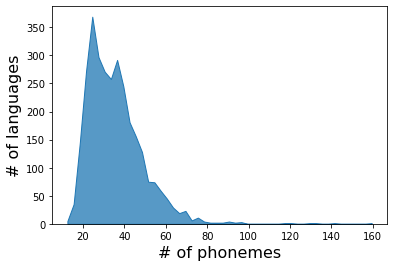

In [11]:
# Let's graph it
import seaborn as sns
import matplotlib.pyplot as plt

plt.xlabel('# of phonemes', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for _, i in res], bins=50, element="poly")
print("Most languages have around 20-50 phonemes, though there are a few with a lot more")

In [12]:
res = engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt DESC
               """
              ).fetchall()

print(f"The languages with the greatest number of vowels are:")
res[:10]

The languages with the greatest number of vowels are:


[('So', 50),
 ('Elfdalian', 50),
 ('Danish', 49),
 ('Scottish Gaelic', 49),
 ('!XU', 46),
 ('PARAUK', 43),
 ('Dan', 40),
 ('Thok Reel', 40),
 ('Karimojong', 39),
 ('Luanyjang Dinka', 39)]

In [13]:
print(f"The languages with the fewest number of vowels are:")
res[-10:]

The languages with the fewest number of vowels are:


[('Darkinyung', 3),
 ('Dharuk', 3),
 ('Eora', 3),
 ('Awabakal', 3),
 ('Nganyaywana', 3),
 ('Ngarigu', 3),
 ('Tableland Lamalama', 3),
 ('Zulgo', 2),
 ('Cuvok', 2),
 ('Buwal', 2)]

In [14]:
res = engine.execute("""
               SELECT x.LanguageName, y.cons_cnt / CAST(x.vowel_cnt AS float) AS ratio FROM
               (SELECT InventoryID, LanguageName, COUNT(*) AS vowel_cnt
               FROM phoible x
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName) AS x
               JOIN
               (SELECT InventoryID, LanguageName, COUNT(*) AS cons_cnt
               FROM phoible x
               WHERE SegmentClass = 'consonant'
               GROUP BY InventoryID, LanguageName) AS y
               ON x.InventoryID = y.InventoryID
               ORDER BY ratio DESC
               """
              ).fetchall()

print(f"The languages with the highest ratio of consonants to vowels are:")
res[:10]

The languages with the highest ratio of consonants to vowels are:


[('Tashlhiyt Berber', 23.666666666666668),
 ('Abkhaz', 22.333333333333332),
 ('Abkhaz', 19.666666666666668),
 ('Buwal', 19.0),
 ('Adyghe', 18.666666666666668),
 ('Moroccan Arabic', 18.5),
 ('Haida', 15.666666666666666),
 ('HAIDA', 15.333333333333334),
 ('Zulgo', 14.5),
 ('Cuvok', 13.5)]

In [15]:
print(f"The languages with the lowest ratio of consonants to vowels are:")
res[-10:]

The languages with the lowest ratio of consonants to vowels are:


[('Lama', 0.5151515151515151),
 ('Luanyjang Dinka', 0.5128205128205128),
 ('Thok Reel', 0.5),
 ('Sanömá of Kolulu', 0.47619047619047616),
 ('Binandere', 0.4583333333333333),
 ('Andoke', 0.4583333333333333),
 ('So', 0.44),
 ('Danish', 0.40816326530612246),
 ('Apinaye', 0.4),
 ('Krahô', 0.35294117647058826)]

Most languages have 2 to 5 consonants per vowel


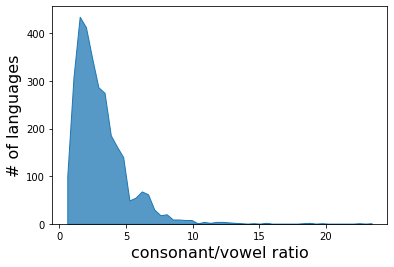

In [16]:
plt.xlabel('consonant/vowel ratio', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for _, i in res], bins=50, element="poly")
print("Most languages have 2 to 5 consonants per vowel")

In [17]:
# Which languages have tones?
res = engine.execute("""
               SELECT DISTINCT(LanguageName)
               FROM phoible
               WHERE tone = '+'
               """
              ).fetchall()

print("These are some of the languages that have tones:")
res[:10]

These are some of the languages that have tones:


[('Burushaski',),
 ('Vietnamese',),
 ('Mandarin Chinese',),
 ('Wu',),
 ('Hakka',),
 ('Cantonese',),
 ('Yao',),
 ('Dafla',),
 ('Burmese',),
 ('Lahu',)]

In [18]:
# Which languages lack nasal sounds i.e. /n/, /m/?
res = engine.execute("""
               SELECT x.LanguageName, SUM(x.nasal) AS num_nasals
               FROM (SELECT InventoryID, LanguageName,
               CASE WHEN nasal = '-' THEN 0 ELSE 1 END AS nasal
               FROM phoible) AS x
               GROUP BY InventoryID, x.LanguageName
               ORDER BY num_nasals ASC
               """
              ).fetchall()

print("These are some unusual languages that lack nasal sounds")
res[:16]

# The final language, Najdi Arabic, definitely contains nasal sounds - so this might be an error!
# Error: https://github.com/phoible/dev/issues/332

These are some unusual languages that lack nasal sounds


[('LUSHOOTSEED', 0),
 ('PIRAHA', 0),
 ('QUILEUTE', 0),
 ('ROTOKAS', 0),
 ('Hup', 0),
 ('Tatuyo', 0),
 ('Xamtanga', 0),
 ('Pirahã', 0),
 ('Barasana-Eduria', 0),
 ('Kubeo', 0),
 ('Desano', 0),
 ('Máíhɨki', 0),
 ('Tatuyo', 0),
 ('Yurutí', 0),
 ('Pisamira', 0),
 ('Najdi Arabic', 0)]

## Language Comparison

In this section, I'm going to get the data into a format that's useful for doing comparisons. There are several ways to do this:

- Map each language to a list of all its phonemes, i.e. `"English": ["a", "e", "i", "b", ...]`
- Map each language to a vector representing the presence of absence of a given phoneme, i.e. `"English": [0, 0, 1, 0, ...]`. This binary vector is equal to the length of all the phonemes in the database.
- Map each language to a vector of vectors, where each sub-vector are the features of each phoneme, i.e `English: [[0, 1, 1, ...], [1, 1, 0, ...], ...]`

Each of these representations allow for different types of distance metrics, so I'll be trying out lots of measurement types. I took inspiration from [this paper](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Gardner_Measuring_Distance_Between_2014_CVPR_paper.pdf) about measuring the distances between sets.

Also, it's important to keep in mind the complexity of these different distance metrics. In order to determine the closest pair of languages, it's necessary to compute the distance between every pair of languages, which is $n^2$ computations. Furthermore, the distance metric itself has its own complexity, which I'll call $d$. That means the complexity of generating all the paired distances between all the languages is actually $dn^2$, which might be large. Luckily, we can ask specific questions instead, like _what is the distance between English and Arabic?_ which has a complexity of just $d$. I'll be using American English for all of my comparisons.

### Overlap Coefficient

The [overlap coefficient](https://en.wikipedia.org/wiki/Overlap_coefficient) is a useful measure of similarity, but is limited when sets are different in size. For instance, a language like _Pirahã_ will be ranked as closer to English than it should be, simply because Pirahã has very few phonemes (and those phonemes happen to be a subset of English's phonemes). In other words, languages with small phoneme inventories like Pirahã will be closer to _every_ other language, so this metric is also measuring "smallness" of a language's phoneme inventory, which we might not care about.

On the other hand, the overlap coefficient might be useful if you consider it _asymmetrically_ - an English speaker who wants to learn Pirahã should have an easier time learning the phonemes than an English speaker learning Thai. However, distance metrics are always symmetrical, so the distance between English and Pirahã is the same as the distance from Pirahã to English - so this metric is only useful when you consider going from a large-inventory language to a small-inventory language, which requires additional logic outside the metric itself.

__Note__: I subtracted the overlap coefficient from `1` in order to convert this to distance: larger values equal greater distance.

In [19]:
# Create mappings like "English": ["a", "e", "i", "b", ...]
simple_mapping = engine.execute("""
               SELECT LanguageName, group_concat(Phoneme)
               FROM phoible
               GROUP BY InventoryID, LanguageName
               """
              ).fetchall()

# Turn this into a dict.
# Warning: this uses LanguageName as the key, which is not unique
# so if there two languages called Chinese, only one will make it into this dict
simple_mapping = {k: v.split(",") for k, v in simple_mapping}

# Show an example.
print(simple_mapping["English (American)"])

['b', 'd', 'd̠ʒ', 'f', 'h', 'j', 'kʰ', 'l', 'm', 'n', 'pʰ', 's', 'tʰ', 't̠ʃ', 'v', 'w', 'z', 'ð', 'ŋ', 'ɡ', 'ɹ', 'ʃ', 'ʒ', 'θ', 'aɪ', 'aʊ', 'eɪ̯', 'iɪ', 'oʊ', 'uː', 'æ', 'ɑ', 'ɔɪ', 'ə', 'ɚː', 'ɛ', 'ɪ', 'ʊ', 'ʌ']


In [20]:
print(f"There are {len(simple_mapping['English (American)'])} phonemes in American English")

There are 39 phonemes in American English


In [21]:
# Define the overlap distance between two sets.
def overlap_distance(a, b):
    a, b = set(a), set(b)
    
    return 1 - len(a.intersection(b)) / min([len(a), len(b)])


# Calculate distances between some languages
overlap_d_eng_pira = overlap_distance(simple_mapping["English (American)"], simple_mapping["Pirahã"])
overlap_d_eng_germ = overlap_distance(simple_mapping["English (American)"], simple_mapping["German"])
overlap_d_eng_thai = overlap_distance(simple_mapping["English (American)"], simple_mapping["Thai"])

print(f"The overlap distance between English and German is {overlap_d_eng_germ:.3f}")
print(f"The overlap distance between English and Thai is {overlap_d_eng_thai:.3f}")
print(f"The overlap distance between English and Pirahã is {overlap_d_eng_pira:.3f}")

The overlap distance between English and German is 0.410
The overlap distance between English and Thai is 0.590
The overlap distance between English and Pirahã is 0.636


In [22]:
# Now let's find the overlap distance between English and every other language.
overlap_distance_to_eng = [(overlap_distance(simple_mapping["English (American)"], simple_mapping[lang]), lang) for lang in simple_mapping]

In [23]:
# Show some of the closest languages to English
sorted(overlap_distance_to_eng, key=lambda x: x[0])[:50]

[(0.0, 'English (American)'),
 (0.1282051282051282, 'American English'),
 (0.28205128205128205, 'English (British)'),
 (0.2962962962962963, 'kwangari'),
 (0.3076923076923077, 'Burmese'),
 (0.3076923076923077, 'English'),
 (0.3076923076923077, 'English (Australian)'),
 (0.31034482758620685, 'Persian'),
 (0.3157894736842105, 'Cebuano'),
 (0.33333333333333337, 'Awtuw'),
 (0.3448275862068966, 'Hanga'),
 (0.3448275862068966, 'Farsi'),
 (0.34782608695652173, 'IVATAN'),
 (0.3571428571428571, 'diriku'),
 (0.36, 'kwezo'),
 (0.375, 'BANDJALANG'),
 (0.375, 'TUNICA'),
 (0.375, 'Daza'),
 (0.375, 'Ndamba'),
 (0.3783783783783784, 'Low German'),
 (0.3783783783783784, 'Scots'),
 (0.38095238095238093, 'Batak'),
 (0.38095238095238093, 'JOMANG'),
 (0.3846153846153846, 'KUNAMA'),
 (0.3846153846153846, 'Ngombale'),
 (0.3846153846153846, 'Salasca Quechua'),
 (0.3846153846153846, 'English (New Zealand)'),
 (0.3846153846153846, 'Welsh'),
 (0.3870967741935484, 'Sherbro'),
 (0.3870967741935484, 'Juhuri'),
 (0.39

The results returned by this algorithm aren't unreasonable: many of the top languages are other English dialects, as well as closely related languages like Scots and German. This is much better than random, but there are some unexpected languages like Burmese. I think we can use an even better distance metric, Jaccard distance, which I introduce in the next section.

### Jaccard Distance

A more generally applicable metric, which accounts for differing set sizes, is the [Jaccard Distance](https://en.wikipedia.org/wiki/Jaccard_index), aka intersection over union. I repeated the same examples below, except I changed the distance metric. Notice that _German_ is ranked as closest to English, which matches our intuition about closeness (Thai and Pirahã are not in the same [language family](https://en.wikipedia.org/wiki/Germanic_languages) that English and German belong to).

In [24]:
# Define the Jaccard distance between two sets.
def jaccard_distance(a, b):
    a, b = set(a), set(b)
    
    return 1 - len(a.intersection(b)) / len(a.union(b))


# Calculate distances between some languages
jaccard_d_eng_pira = jaccard_distance(simple_mapping["English (American)"], simple_mapping["Pirahã"])
jaccard_d_eng_germ = jaccard_distance(simple_mapping["English (American)"], simple_mapping["German"])
jaccard_d_eng_thai = jaccard_distance(simple_mapping["English (American)"], simple_mapping["Thai"])

print(f"The Jaccard distance between English and German is {jaccard_d_eng_germ:.3f}")
print(f"The Jaccard distance between English and Thai is {jaccard_d_eng_thai:.3f}")
print(f"The Jaccard distance between English and Pirahã is {jaccard_d_eng_pira:.3f}")

The Jaccard distance between English and German is 0.589
The Jaccard distance between English and Thai is 0.771
The Jaccard distance between English and Pirahã is 0.913


In [25]:
# Now let's find the jaccard distance between English and every other language.
jaccard_distance_to_eng = [(jaccard_distance(simple_mapping["English (American)"], simple_mapping[lang]), lang) for lang in simple_mapping]

In [26]:
# Show some of the closest languages to English
sorted(jaccard_distance_to_eng, key=lambda x: x[0])[:50]

[(0.0, 'English (American)'),
 (0.2272727272727273, 'American English'),
 (0.43999999999999995, 'English (British)'),
 (0.4807692307692307, 'English'),
 (0.5178571428571428, 'English (Australian)'),
 (0.5660377358490566, 'Low German'),
 (0.5660377358490566, 'Scots'),
 (0.5740740740740741, 'BASHKIR'),
 (0.5740740740740741, 'Northern Kurdish'),
 (0.5833333333333333, 'Persian'),
 (0.5892857142857143, 'German'),
 (0.5909090909090908, 'Burmese'),
 (0.5957446808510638, 'kwangari'),
 (0.6, 'English (New Zealand)'),
 (0.6037735849056604, 'Teda'),
 (0.6037735849056604, 'Belizean Creole'),
 (0.6071428571428572, 'greek Thrace Xoraxane Romane'),
 (0.607843137254902, 'Daza'),
 (0.6122448979591837, 'Hanga'),
 (0.6122448979591837, 'Farsi'),
 (0.6190476190476191, 'Welsh'),
 (0.6226415094339622, 'Azerbaijani'),
 (0.625, 'KOHUMONO'),
 (0.625, 'Siwi'),
 (0.6271186440677966, 'Halbi'),
 (0.6274509803921569, 'Sherbro'),
 (0.6274509803921569, 'Juhuri'),
 (0.6296296296296297, 'Maltese'),
 (0.6296296296296297,

The results returned by this algorithm seem reasonable. The closest languages to "English" are other English dialects and German, a closely related language. Most of the other languages on the list make sense: they're English-based creoles, Western European languages, languages influenced by British colonization (Maltest), or other Indo-European languages. Some languages, however, seem out of place: there are many languages from the Niger-Congo family and some Austronesian languages. We'll see if the same kind of languages are returned by the other metrics.

### Simple Matching Coefficient

[The Simple Matching Coefficient](https://en.wikipedia.org/wiki/Simple_matching_coefficient) for two equal-length arrays is the number of matching elements divided by the length of the array. This only works for vectors that are equal length, so below I map each language to a binary vector that represents the presence or absence of a given phoneme.

Because the average inventory size is 34.9 (see above) and the total number of phonemes is 3164 (see below), each binary vector will be sparse (mostly zeros), meaning that distance measures will all be _close_ to each other. However, even though the numbers themselves are close, distance can still be ranked, and the total differences can always be scaled.

I subtracted this coefficient from `1` to turn it into a distance metric.

Note: [Hamming Distance](https://en.wikipedia.org/wiki/Hamming_distance) is the same as the simple matching coefficient except is defined between equal-length strings instead of equal-length arrays.

In [27]:
phoneme_list = engine.execute("""
                SELECT GROUP_CONCAT(DISTINCT(Phoneme)) FROM phoible
               """
              ).fetchall()

# List of distinct phonemes
total_phoneme_inventory = list(phoneme_list[0])[0].split(",")
print(f"Here is what some of the phoneme data looks like: {total_phoneme_inventory[:10]}")
print(f"There are {len(total_phoneme_inventory)} phonemes total")

Here is what some of the phoneme data looks like: ['h', 'j', 'k', 'kʰ', 'kˀ', 'l', 'm', 'n', 'p', 'pʰ']
There are 3164 phonemes total


In [28]:
# Create mapping like "English": [1, 1, 0, 1, ...]
def create_binary_encoding(language_phoneme_inventory, total_phoneme_inventory=total_phoneme_inventory):
    return [1 if phone in language_phoneme_inventory else 0 for phone in total_phoneme_inventory]


binary_encoding = {k: create_binary_encoding(v) for k, v in simple_mapping.items()}

In [29]:
# Show what part of the binary encoding for English looks like
binary_encoding["English (American)"][:10]

[1, 1, 0, 1, 0, 1, 1, 1, 0, 1]

In [30]:
# Confirm the number of phonemes in American English
sum(binary_encoding["English (American)"])

39

In [31]:
# Define the simple matching coefficient between two equal-length vectors
def simple_matching_coef(a, b):
    len_overlap = len([1 for i, j in zip(a, b) if i == j])
    
    return 1 - len_overlap / len(a)


# Calculate distances between some languages
simple_matching_d_eng_pira = simple_matching_coef(binary_encoding["English (American)"], binary_encoding["Pirahã"])
simple_matching_d_eng_germ = simple_matching_coef(binary_encoding["English (American)"], binary_encoding["German"])
simple_matching_d_eng_thai = simple_matching_coef(binary_encoding["English (American)"], binary_encoding["Thai"])

print(f"The Simple matching coefficient for English and German is {simple_matching_d_eng_germ:.3f}")
print(f"The Simple matching coefficient for English and Thai is {simple_matching_d_eng_thai:.3f}")
print(f"The Simple matching coefficient for English and Pirahã is {simple_matching_d_eng_pira:.3f}")

The Simple matching coefficient for English and German is 0.010
The Simple matching coefficient for English and Thai is 0.017
The Simple matching coefficient for English and Pirahã is 0.013


In [32]:
# Now let's find the matching distance between English and every other language.
simple_distance_to_eng = [(simple_matching_coef(simple_mapping["English (American)"], simple_mapping[lang]), lang) for lang in simple_mapping]

In [33]:
# Show some of the closest languages to English
sorted(simple_distance_to_eng, key=lambda x: x[0])[:50]

[(0.0, 'English (American)'),
 (0.15384615384615385, 'American English'),
 (0.3589743589743589, 'English (British)'),
 (0.4358974358974359, 'English (New Zealand)'),
 (0.6153846153846154, 'Bassa'),
 (0.6153846153846154, 'Belizean Creole'),
 (0.6153846153846154, 'Bakhtiari'),
 (0.6153846153846154, 'Jèrriais'),
 (0.641025641025641, "Fe'efe'fe"),
 (0.641025641025641, 'Lunda'),
 (0.641025641025641, 'Jamaican Creole'),
 (0.641025641025641, 'Sisumbwa'),
 (0.641025641025641, 'Kera'),
 (0.641025641025641, 'Juhuri'),
 (0.6666666666666667, 'English'),
 (0.6666666666666667, 'limbum (central)'),
 (0.6666666666666667, 'limbum (northern)'),
 (0.6666666666666667, 'Pichi'),
 (0.6666666666666667, 'Ndamba'),
 (0.6666666666666667, 'Minangkabau'),
 (0.6923076923076923, 'KANURI'),
 (0.6923076923076923, 'Adja'),
 (0.6923076923076923, 'Minyanka'),
 (0.6923076923076923, 'Indonesian'),
 (0.6923076923076923, 'Sherbro'),
 (0.717948717948718, 'Angas'),
 (0.717948717948718, 'Persian'),
 (0.717948717948718, 'BAMBAR

The results returned by this algorithm also seem reasonable. Again, many of the closest languages are other English dialects, other Indo-European langauges, and some creole languages.

### Vector Space Similarity

In this algorithm, I first map each phoneme to a set of binary features. There are 37 of these features. When comparing two languages, I calculate the distance between each phoneme in each language and take the average of the closest features. The sub-distance metric I use is jaccard distance. 


In [34]:
# Columns 11 and onward are phoneme feature columns
cols = list(df.columns[9:])
cols.pop(1) # Remove Source, which is not a segment feature
print(cols)
print(f"There are {len(cols)} segment features total")

['SegmentClass', 'tone', 'stress', 'syllabic', 'short', 'long', 'consonantal', 'sonorant', 'continuant', 'delayedRelease', 'approximant', 'tap', 'trill', 'nasal', 'lateral', 'labial', 'round', 'labiodental', 'coronal', 'anterior', 'distributed', 'strident', 'dorsal', 'high', 'low', 'front', 'back', 'tense', 'retractedTongueRoot', 'advancedTongueRoot', 'periodicGlottalSource', 'epilaryngealSource', 'spreadGlottis', 'constrictedGlottis', 'fortis', 'raisedLarynxEjective', 'loweredLarynxImplosive', 'click']
There are 38 segment features total


In [35]:
# Make language mapping like English: [[0, 1, 1, ...], [1, 1, 0, ...], ...]
res = engine.execute(f"""
               SELECT LanguageName ||","|| {"||".join(df.columns[11:])}
               FROM phoible
               """
              ).fetchall()

res = [[i[0].split(",")[0], list(i[0].split(",")[1])]for i in list(res)]

vector_mapping = {}
for lang, phoneme in res:
    if lang not in vector_mapping:
        vector_mapping[lang] = [phoneme]
    else:
        vector_mapping[lang].append(phoneme)

In [36]:
vector_mapping["English (American)"][:2]

[['0',
  '-',
  '-',
  '-',
  '-',
  '+',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '+',
  '-',
  '-',
  '-',
  '0',
  '0',
  '0',
  '-',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '+',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['0',
  '-',
  '-',
  '-',
  '-',
  '+',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '0',
  '0',
  '+',
  '+',
  '-',
  '-',
  '-',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '+',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-']]

In [37]:
# Define the vector space similarity between two languages
def vector_similarity(a, b):
    """
    Calculate the jaccard distance between all of a's vectors and all of b's vectors
    The overall vector space similarity is simply the average distance.
    This works fine where the phoneme inventories are different sizes
    """
    simple_distances = []
    
    # For each vector in a, find the closest vector in b and append it to simple_distances
    for vec_a in a:
        closest = 1
        for vec_b in b:
            distance = simple_matching_coef(vec_a, vec_b)
            if distance < closest:
                closest = distance
        simple_distances.append(closest)
    
    # For each vector in b, find the closest in a
    for vec_b in b:
        closest = 1
        for vec_a in a:
            distance = simple_matching_coef(vec_a, vec_b)
            if distance < closest:
                closest = distance
        simple_distances.append(closest)
    
    # Return the average distance
    return sum(simple_distances) / len(simple_distances)


# Calculate distances between some languages
vec_similarity_d_eng_pira = vector_similarity(vector_mapping["English (American)"], vector_mapping["Pirahã"])
vec_similarity_d_eng_germ = vector_similarity(vector_mapping["English (American)"], vector_mapping["German"])
vec_similarity_d_eng_thai = vector_similarity(vector_mapping["English (American)"], vector_mapping["Thai"])

print(f"The Simple matching coefficient for English and German is {vec_similarity_d_eng_germ:.3f}")
print(f"The Simple matching coefficient for English and Thai is {vec_similarity_d_eng_thai:.3f}")
print(f"The Simple matching coefficient for English and Pirahã is {vec_similarity_d_eng_pira:.3f}")

The Simple matching coefficient for English and German is 0.011
The Simple matching coefficient for English and Thai is 0.075
The Simple matching coefficient for English and Pirahã is 0.050


In [38]:
# Now let's find the matching distance between English and every other language.
# Be patient, this might take a minute!
vec_distance_to_eng = [(vector_similarity(vector_mapping["English (American)"], vector_mapping[lang]), lang) for lang in vector_mapping]

In [56]:
# Show some of the closest languages to English
top_langs = sorted(vec_distance_to_eng, key=lambda x: x[0])[:50]
top_langs

[(0.0, 'English (American)'),
 (0.0010395010395010374, 'American English'),
 (0.0023752566125447463, 'English (British)'),
 (0.004353751341703147, 'English (Australian)'),
 (0.00437247063013934, 'English'),
 (0.007400257400257397, 'English (New Zealand)'),
 (0.009130752373995611, 'Belizean Creole'),
 (0.010135135135135125, 'Jamaican Creole'),
 (0.01060939861160004, 'German'),
 (0.010933382361953783, 'Breton'),
 (0.010987999493746611, 'Welsh'),
 (0.01105651105651105, 'Frisian'),
 (0.011183597390493932, 'Assamese'),
 (0.011880011880011872, 'Mo'),
 (0.012091038406827874, 'Scots'),
 (0.01218119527978682, 'Daza'),
 (0.01241782322863403, 'Wymysorys'),
 (0.012679346012679338, 'Dogon'),
 (0.012854317732366507, 'Tamasheq'),
 (0.012884978001257064, 'Kabiyɛ'),
 (0.012942519984773497, 'Karipuna Creole'),
 (0.013323182337266835, 'Lunda'),
 (0.013362430753735088, 'Rumanian'),
 (0.013391272801835967, 'French'),
 (0.013513513513513504, 'BAMBARA'),
 (0.013513513513513504, 'Antiguan Creole'),
 (0.013689

The results here look even better than simple Jaccard distance: the top languages are all English dialects or related languages, languages spoken in the British Isles (Wales), other Indo-European languages, or languages that have been strongly influenced by English (Maltese, Jamaican Creole, Belizean Creole), or the usual Niger-Congo and Austronesian languages. There are some outliers though, like _Tamasheq_, a Berber language spoken in Mali, but [its phonology](https://en.wikipedia.org/wiki/Tamasheq_language#Phonology) does look similar to English.

In the next section, I'm going to be a little more specific in how I measure the success of this distance metric.

## Evaluation

One way to evaluate this custom distance metric is to simply look at the results: do they look sensible? A "sensible" result should have lots of languages in the same family as English: Indo-European. If a lot of the results are Indo-European, then the results are probably good. This seems to be the cast. Rather than just counting things manually, let's quantify it.

In this section I first join the phoible dataset with [glottolog](https://glottolog.org/). Glottolog contains meta-data about languages: where it's spoken, the countries it's spoken in, etc. The variable I care about is the _language family_. After I get this information, I use [WALS](https://wals.info/languoid) to get the relevant frequencies of the world's language families. For instance, if my algorithm's top-50 items contain 25 Indo-European languages, and 50% of the world's languages are members of this family, then the algorithm's results are probably random. If, however, the distribution of language families that are selected by my algorithm are significantly different from the distribution in WALS, that means that my algorithm is doing _something_.

Here is how I evaluate the results:
- If there are significantly __more__ Indo-European languages chosen than random, then my algorithm is _valid_ - it's returning sensible results.
- If my algorithm returns _some other language family_ significantly more than chance, then this family _probably_ resembles English in its phonology. Sneak peak: Niger-Congo languages are disproportionately selected.

First I'll just show you the raw probabilities, then I'll use statistics to quantify things.

In [40]:
! curl https://raw.githubusercontent.com/glottolog/glottolog-cldf/master/cldf/languages.csv > languages.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1547k  100 1547k    0     0  3357k      0 --:--:-- --:--:-- --:--:-- 3364k


In [41]:
! mv languages.csv ../data

In [42]:
lang_df = pd.read_csv("../data/languages.csv")

In [43]:
lang_df.head()

,ID,Name,Macroarea,Latitude,Longitude,Glottocode,ISO639P3code,Countries,Family_ID,Language_ID
0,kond1302,Konda-Yahadian,NaN,NaN,NaN,kond1302,NaN,NaN,NaN,NaN
1,cani1243,Canichana,South America,-14.3058,-64.944455,cani1243,caz,BO,NaN,NaN
2,mong1349,Mongolic-Khitan,NaN,NaN,NaN,mong1349,NaN,NaN,NaN,NaN
3,cadd1255,Caddoan,NaN,NaN,NaN,cadd1255,NaN,NaN,NaN,NaN
4,yuki1242,Yuki-Wappo,NaN,NaN,NaN,yuki1242,NaN,NaN,NaN,NaN


In [55]:
# Join phoible to glottolog to see which languages are part of the indo-european family
engine = create_engine('sqlite://', echo=False)
lang_df.to_sql('glottolog', con=engine)
df.to_sql('phoible', con=engine)

res = engine.execute("""
               SELECT DISTINCT(phoible.LanguageName), glottolog.Family_ID FROM glottolog
               JOIN phoible
               ON phoible.Glottocode = glottolog.Glottocode
               WHERE Family_ID LIKE '%indo%'
               """
              ).fetchall()

res[:10]

[('GREEK', 'indo1319'),
 ('Greek', 'indo1319'),
 ('Modern Greek', 'indo1319'),
 ('Italian', 'indo1319'),
 ('Aragonese', 'indo1319'),
 ('Ligurian', 'indo1319'),
 ('Friulian', 'indo1319'),
 ('Vallader Romansh', 'indo1319'),
 ('Reunionnais', 'indo1319'),
 ('Mauritian Creole', 'indo1319'),
 ('Karipuna Creole', 'indo1319'),
 ('FRENCH', 'indo1319'),
 ('French', 'indo1319'),
 ('Jèrriais', 'indo1319'),
 ('Catalan', 'indo1319')]

In [58]:
lang_names = [name for _, name in top_langs]

In [83]:
# Organize by language family
engine = create_engine('sqlite://', echo=False)
lang_df.to_sql('glottolog', con=engine)
df.to_sql('phoible', con=engine)

res = engine.execute(f"""
               SELECT DISTINCT(phoible.LanguageName), glottolog.Family_ID FROM glottolog
               JOIN phoible
               ON phoible.Glottocode = glottolog.Glottocode
               AND phoible.LanguageName IN ('{"','".join(lang_names)}')
               """
              ).fetchall()

sorted(res, key=lambda x: x[1])[:15]

[('Mwaghavul', 'afro1255'),
 ('Tamasheq', 'afro1255'),
 ('AMO', 'atla1278'),
 ('Berom', 'atla1278'),
 ('Kabiyɛ', 'atla1278'),
 ('Mo', 'atla1278'),
 ('Vagala', 'atla1278'),
 ('Hill Jarawa', 'atla1278'),
 ('Lunda', 'atla1278'),
 ('limbum (central)', 'atla1278'),
 ('So', 'aust1305'),
 ('Tagalog', 'aust1307'),
 ('Indonesian', 'aust1307'),
 ('Bakairí', 'cari1283'),
 ('Dogon', 'dogo1299')]

In [85]:
print(f"The fraction of Indo-European languages in the top-50 is: {len([i for i in res if i[1] == 'indo1319'])/len(res)*100:.0f}%")
print(f"The fraction of Niger-Congo languages in the top-50 is: {len([i for i in res if i[1] == 'atla1278'])/len(res)*100:.0f}%")
african_languages = ['atla1278', 'saha1256', 'song1307', 'afro1255', 'dogo1299']
print(f"The fraction of African languages in the top-50 is: {len([i for i in res if i[1] in african_languages])/len(res)*100:.0f}%")

The fraction of Indo-European languages in the top-50 is: 52%
The fraction of Niger-Congo languages in the top-50 is: 16%
The fraction of African languages in the top-50 is: 28%


In [82]:
len_WALS = 2662
len_WALS_niger_congo = 325
len_WALS_indo_euro = 176
print(f"The fraction of Indo-European languages in WALS is {len_WALS_indo_euro/len_WALS*100:.0f}%")
print(f"The fraction of Niger-Congo languages in WALS is {len_WALS_niger_congo/len_WALS*100:.0f}%")

The fraction of Indo-European languages in WALS is 7%
The fraction of Niger-Congo languages in WALS is 12%


- introduce WALS for baseline comparisons
- introduce glottolog for language metadata

model-based approach:
- create labels, perhaps based off the criteria: 1 = Indo-European, 0 = non-Indo-European
- train a classifier on the model - hopefully it will be accurace (f1 score)
- classify all the languages
- sort the languages by probability of being indo-european
- alternatively: train a regression classifier, where there are a few features: English, Germanic, Indo

## Conclusion

Niger-Congo and Austronesian languages sound similar to English - broadly speaking. If you're an English speaker and want to pick a new language to study, maybe consider a language from one of these families! The grammar or writing might still be challenging, but you'll at least know that pronunciation won't stop you.

__Note for developers__: feel free to modify this code to perform your own analyses. I used American English for the basis of my comparisons, but in principle you can perform many other kinds of comparisons.